In [47]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from dython.nominal import associations
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import DataPrep as dtp

In [48]:
df = dtp.readData('spotifyData.csv')
df.head()

,title,artist,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness
0,"Hey, Soul Sister",Train,neo mellow,2010,97.0,89.0,67.0,NaN,8.0,80.0,217.0,19.0,4.0,83.0,16.920,92.16
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82.0,30.456,73.92
2,TiK ToK,Kesha,dance pop,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80.0,24.534,82.56
3,Bad Romance,Lady Gaga,dance pop,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,NaN,24.534,92.16
4,Just the Way You Are,Bruno Mars,pop,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78.0,48.222,92.16


# EDA 

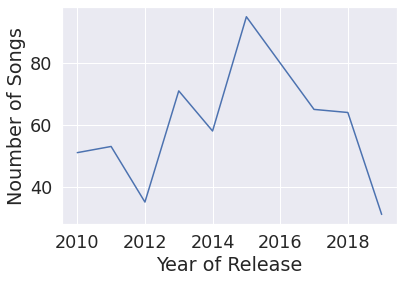

In [49]:
new_df = df[['year','title']].groupby('year').count()

sns.lineplot(x='year',y='title',data=new_df)

plt.ylabel('Noumber of Songs')
plt.xlabel('Year of Release')
plt.show()

Top of 10 genres from 2010 to 2019

In [50]:
def get_top_df(df, top = 10): #change 'top' value to see another top 

    top_lst = df.iloc[:]['genre'].value_counts().index[top:]
    df_other = df.replace(top_lst, 'Other')
    order_lst = list(df_other['genre'].value_counts().index)
    order_lst.remove('Other') #remove first 'Other'
    order_lst.append('Other') #append to the end 'Other'

    return df_other, order_lst

Text(0.5, 10.255999999999986, 'Number of songs')

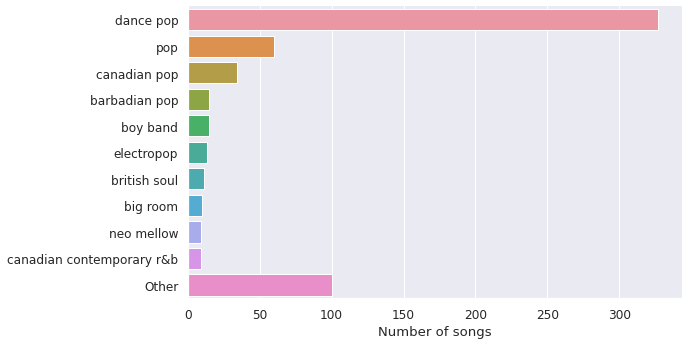

In [51]:
sns.set(font_scale=1.1)

df_top, order_lst = get_top_df(df)

sns.catplot(y = 'genre', data = df_top, kind = 'count', order= order_lst, aspect=2)
plt.ylabel('')
plt.xlabel('Number of songs')



Text(0.5, 10.255999999999986, 'Number of songs')

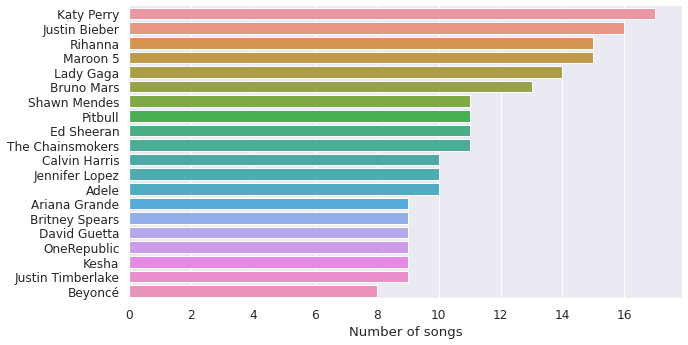

In [52]:
sns.set(font_scale=1.1)

order = df['artist'].value_counts().index[:20]

sns.catplot(y = 'artist', data = df_top, kind = 'count', aspect=2, order = order)
plt.ylabel('')
plt.xlabel('Number of songs')


Percentage normalization

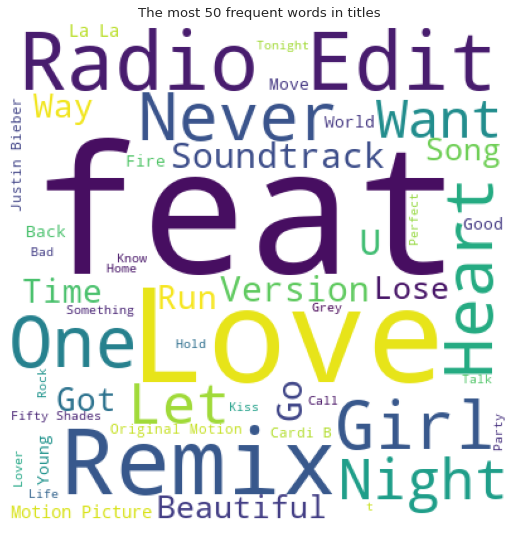

In [53]:
wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', max_words = 50, colormap="viridis",
                min_font_size = 10).generate(" ".join(df['title']))

plt.figure(figsize=(7, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"The most {50} frequent words in titles")
plt.show()

Top of 3 genres from 2010 to 2019

In [54]:
counted_genre = df.groupby(['genre', 'year']).size().unstack(fill_value=0)

In [55]:
df1 = pd.DataFrame()
for i in list(counted_genre.columns):
    df2 = counted_genre[i].sort_values(ascending=False)[:3]
    dict = {'Amount of songs': list(df2.values), 'genre': df2.index, 'year':i}
    tmp = pd.DataFrame(dict)
    df1 = df1.append(tmp, ignore_index=True)

Text(0, 0.5, 'Amount of songs')

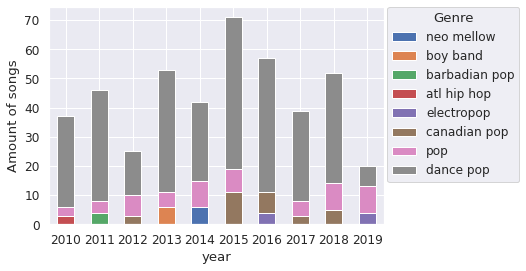

In [56]:
orderOfgenres = df1['genre'].value_counts().index[: : -1]
ax = df1.pivot(index='year', columns='genre', values='Amount of songs').iloc[:][orderOfgenres].plot(kind='bar', stacked=True, rot=0)

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title = "Genre")
plt.ylabel('Amount of songs')

### Fix nan values with median value

In [57]:
dtp.fixNanWithMedian(df)
df.isnull().any()

title               False
artist              False
genre               False
year                False
beats per minute     True
energy              False
danceability        False
loudness dB         False
liveness            False
valence             False
duration            False
acousticness        False
speechiness         False
popularity          False
bad feeling         False
instrumentalness    False
dtype: bool

### Fixing nan values with KNNImputer using the method described in:
https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505

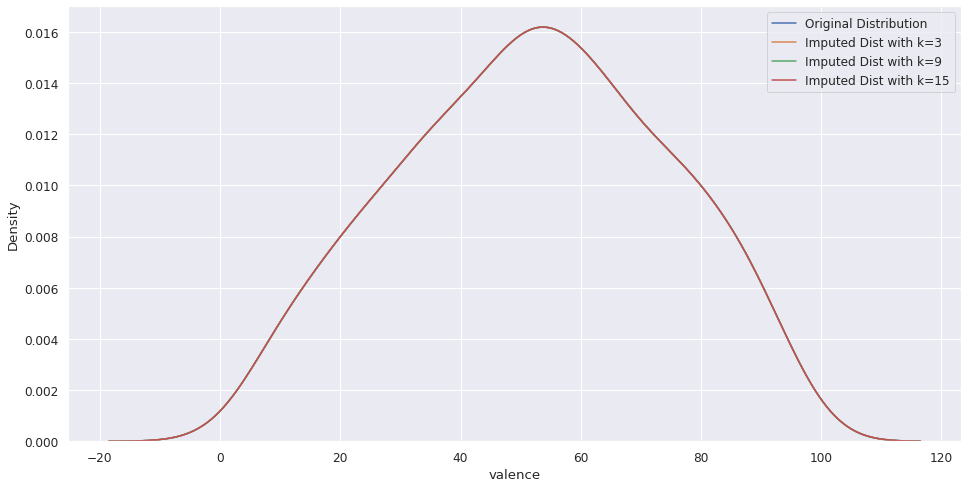

In [58]:
from sklearn.impute import KNNImputer

df_tmp = df.copy()
n_neighbors = [3, 9, 15]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(df['valence'], label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    df_tmp.iloc[:, 4:] = knn_imp.fit_transform(df.iloc[:, 4:])
    sns.kdeplot(df_tmp['valence'], label=f"Imputed Dist with k={k}")

plt.legend()

In the above plot, we compare the different KNN imputations for the features using Probability Density plots. The closer the imputed distribution comes to the original, the better was the imputation.

Here, it seems k=3 is the best choice.

In [59]:
knn_imp = KNNImputer(n_neighbors=3)
df.iloc[:, 4:] = knn_imp.fit_transform(df.iloc[:, 4:])

In [60]:
df[df['beats per minute'].isnull()]

,title,artist,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness


In [61]:
dtp.fillMissingValue(df, index = 273, feature = 4, filler = 129) # filler value found on the internet

### Correlation Heatmap

Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using:

* Pearson's R for continuous-continuous cases
* Correlation Ratio for categorical-continuous cases
* Cramer's V or Theil's U for categorical-categorical cases

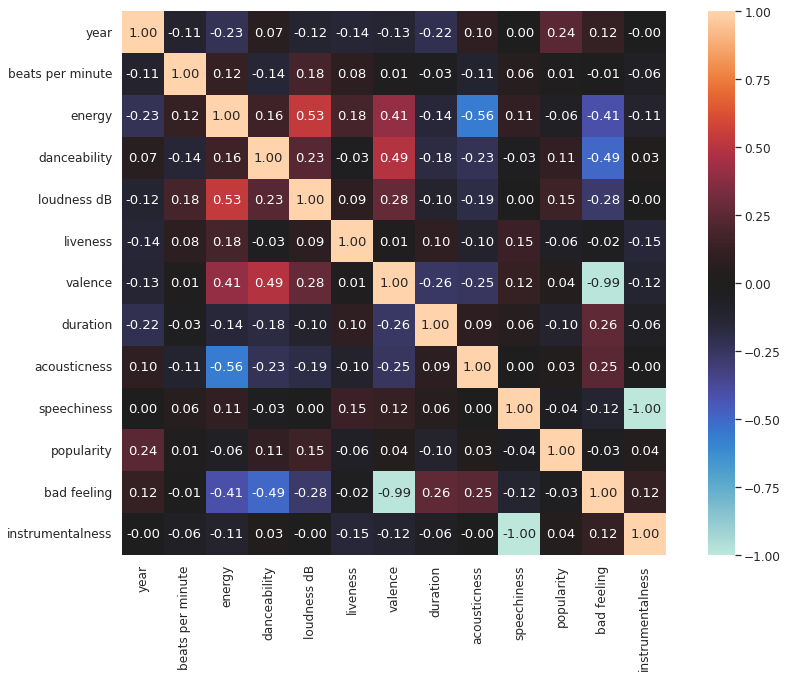

In [62]:
complete_correlation= associations(df.iloc[:, 3:], figsize=(15,10), clustering = False)

We find 2 redundant features that are perfectly negatively correlated to other features, we remove them

In [63]:
dtp.removeRedundant(df, ["instrumentalness", "bad feeling"])

<AxesSubplot:xlabel='valence', ylabel='danceability'>

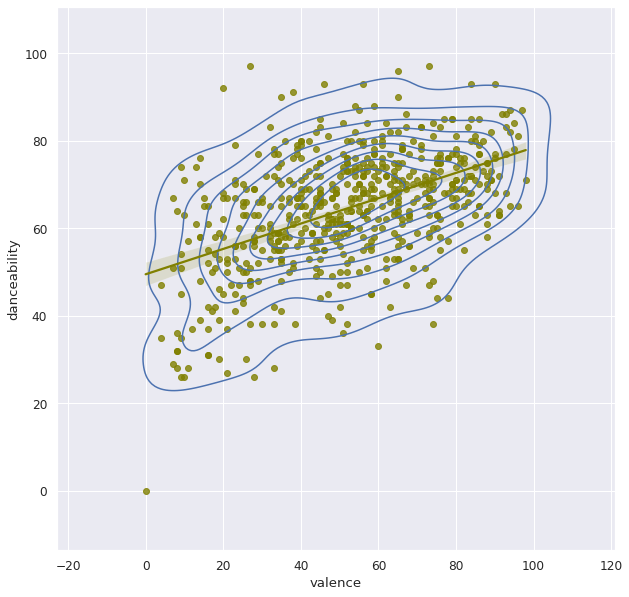

In [64]:
fig = plt.subplots(figsize = (10,10))

sns.regplot(x = 'valence', y = 'danceability', data = df, color = 'olive')

sns.kdeplot(df['valence'], df['danceability'])

If song is at more positive mood than it's more danceable

<AxesSubplot:xlabel='loudness dB', ylabel='energy'>

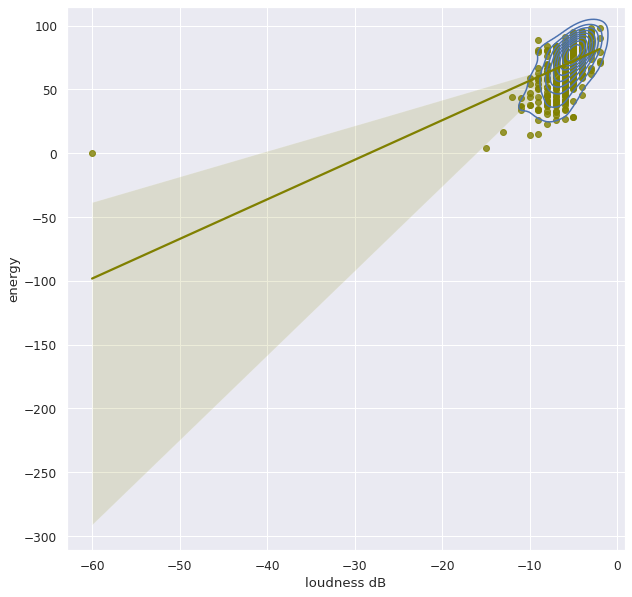

In [65]:
fig = plt.subplots(figsize = (10,10))

sns.regplot(x = 'loudness dB', y = 'energy', data = df, color = 'olive')

sns.kdeplot(df['loudness dB'], df['energy'])

energy and acousticness are negativly correletad, also we found one really weird value with coordinates (0, 0). We should check it

In [66]:
df[df['valence'] == 0]

,title,artist,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity
442,Million Years Ago,Adele,british soul,2016,0.0,0.0,0.0,-60.0,0.0,0.0,227.0,0.0,0.0,0.0


Adele's song Million years ago is a huge outlier with many null values and very small dB, likely an entry error, we remove it from the dataframe.

In [67]:
dtp.dropOutlier(df, 442)

In [68]:
#sns.pairplot(df.iloc[:, 4:])

<AxesSubplot:xlabel='valence', ylabel='danceability'>

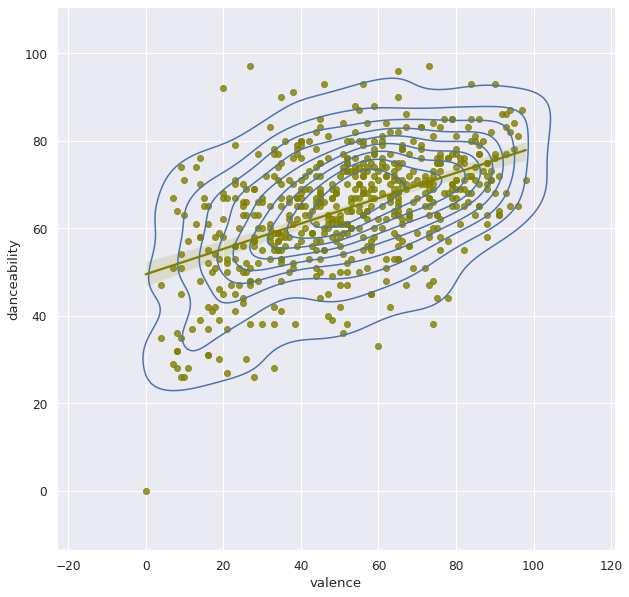

In [69]:
fig = plt.subplots(figsize = (10,10))

sns.regplot(x = 'valence', y = 'danceability', data = df, color = 'olive')

sns.kdeplot(df['valence'], df['danceability'])

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,603.0,2014.592040,2.607057,2010.0,2013.0,2015.0,2017.0,2019.0
beats per minute,603.0,118.502488,24.652224,0.0,100.0,120.0,129.0,206.0
energy,603.0,70.470978,16.292093,0.0,61.0,74.0,82.0,98.0
danceability,603.0,64.515755,13.170653,0.0,57.0,66.0,73.0,97.0
loudness dB,603.0,-5.592040,2.798208,-60.0,-6.0,-5.0,-4.0,-2.0
liveness,603.0,17.711443,12.913190,0.0,9.0,12.0,24.0,74.0
valence,603.0,51.984245,22.213929,0.0,35.0,52.0,68.0,98.0
duration,603.0,224.718076,34.105954,134.0,202.0,221.0,239.5,424.0
acousticness,603.0,14.313433,20.768210,0.0,2.0,6.0,17.0,99.0
speechiness,603.0,8.351575,7.483921,0.0,4.0,5.0,9.0,48.0


In [71]:
order = df['genre'].value_counts()[df['genre'].value_counts().values > 10].index # get sorted genres with more than 10 songs 

### We can to find something intresting here

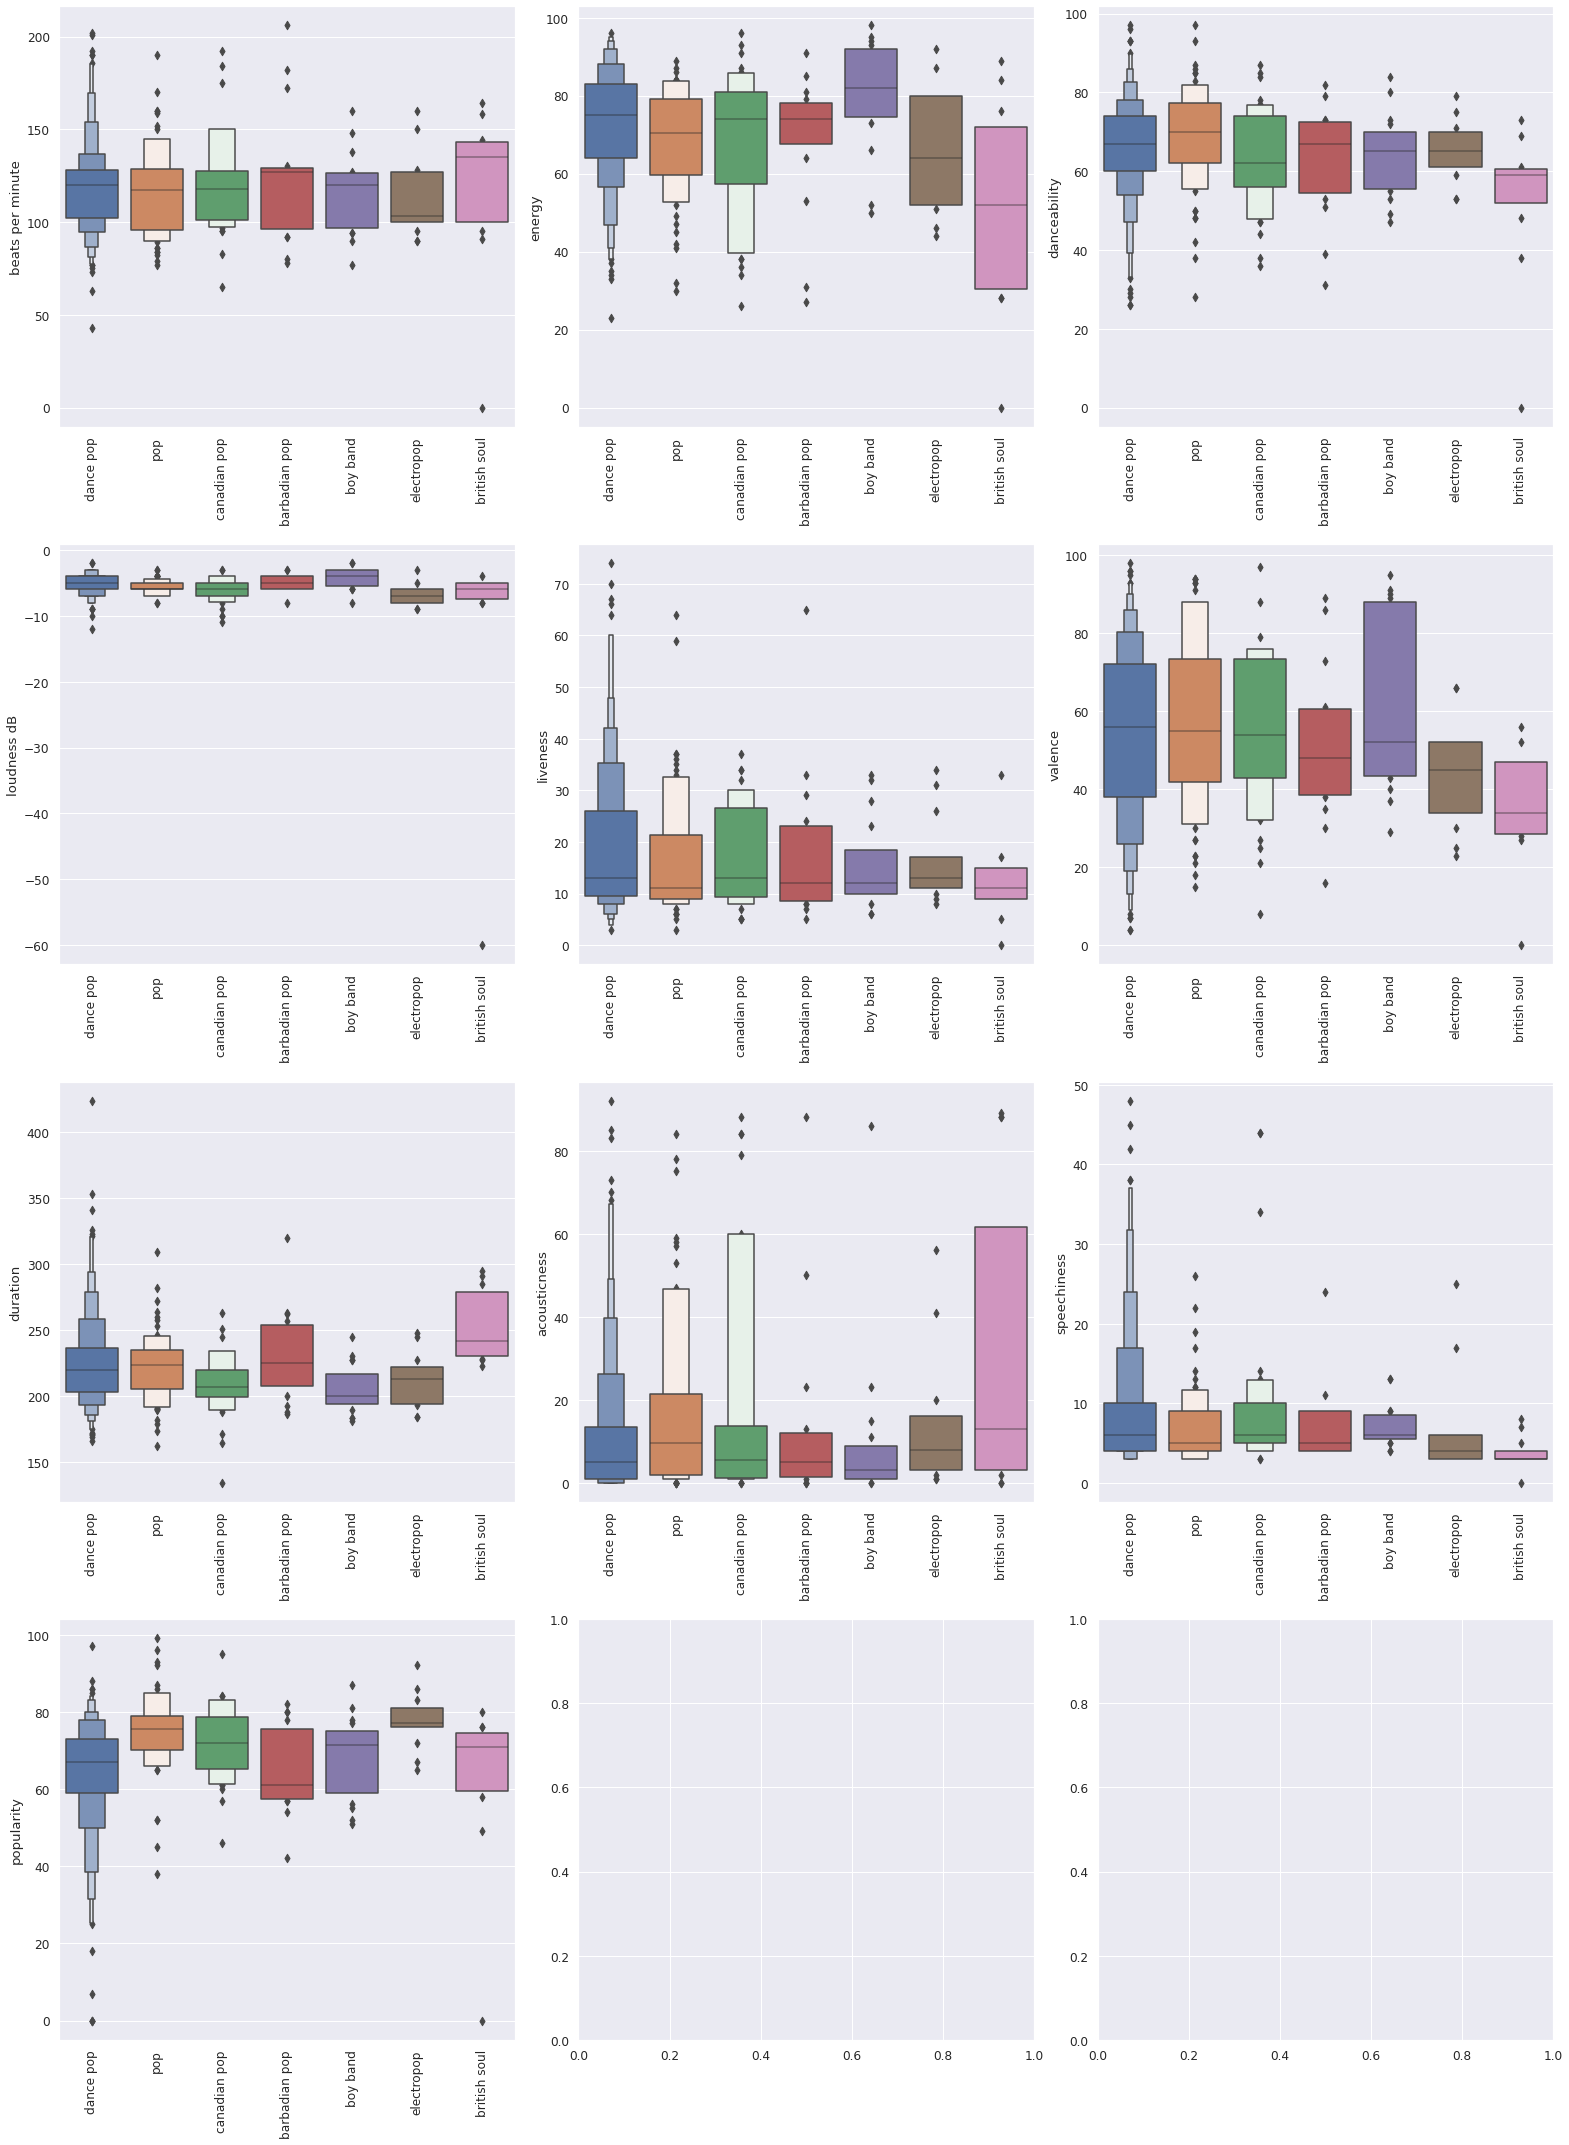

In [72]:
numerical_cols = df.drop('year', axis= 1).select_dtypes('number').columns.to_list()

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(22,30))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    #sns.catplot(y=col, x="top.genre", kind="boxen", data=df, order = order)
    sns.boxenplot(data=df, x='genre', y= col, order = order)
    plt.xlabel("")
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

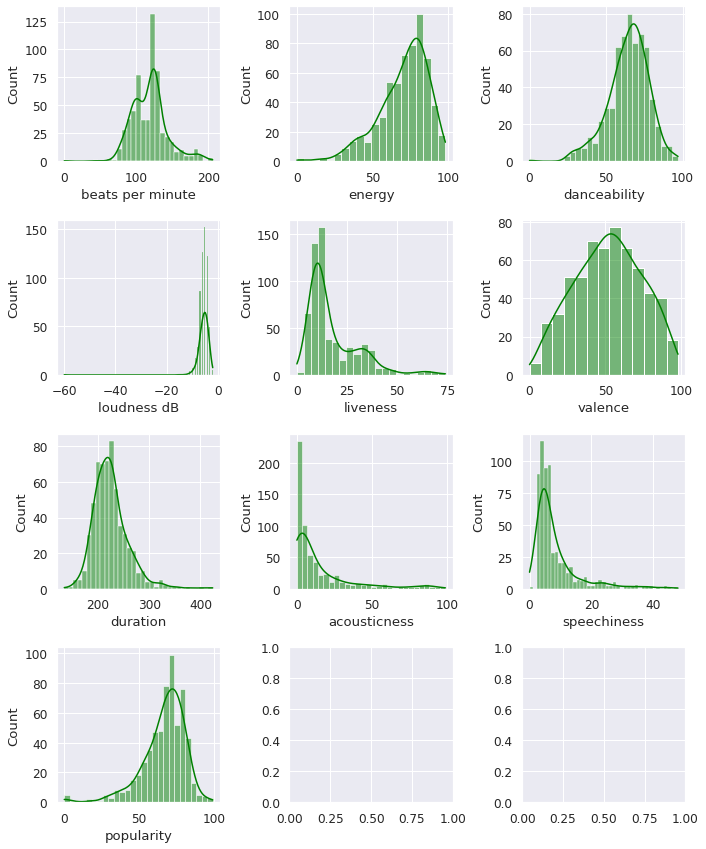

In [73]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,12))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    sns.histplot(data=df, x=col, kde=True, color='green')

plt.tight_layout()
plt.show()

* dnce, val, dur, emo, pop have an appoximately normal distribution.

* nrgy, dB, ins features are right Skewed

* live, acous, spch features are Left Skewed

#### Number of songs for each year

In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,603.0,2014.592040,2.607057,2010.0,2013.0,2015.0,2017.0,2019.0
beats per minute,603.0,118.502488,24.652224,0.0,100.0,120.0,129.0,206.0
energy,603.0,70.470978,16.292093,0.0,61.0,74.0,82.0,98.0
danceability,603.0,64.515755,13.170653,0.0,57.0,66.0,73.0,97.0
loudness dB,603.0,-5.592040,2.798208,-60.0,-6.0,-5.0,-4.0,-2.0
liveness,603.0,17.711443,12.913190,0.0,9.0,12.0,24.0,74.0
valence,603.0,51.984245,22.213929,0.0,35.0,52.0,68.0,98.0
duration,603.0,224.718076,34.105954,134.0,202.0,221.0,239.5,424.0
acousticness,603.0,14.313433,20.768210,0.0,2.0,6.0,17.0,99.0
speechiness,603.0,8.351575,7.483921,0.0,4.0,5.0,9.0,48.0


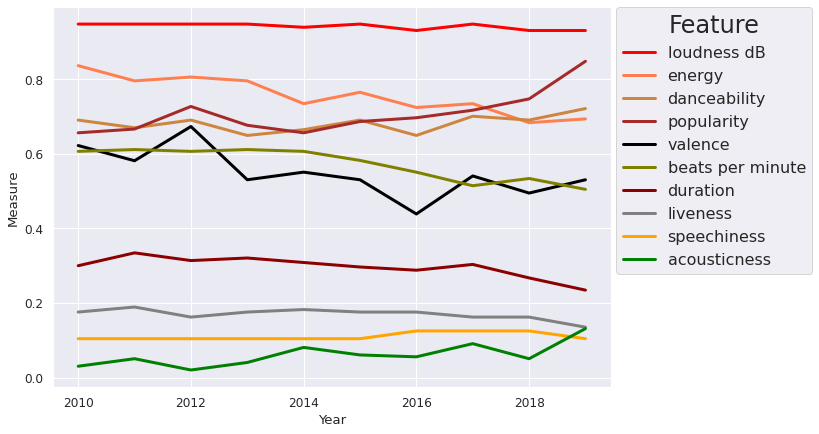

In [75]:
df_norm = dtp.normalize(df)
columns = df.columns[4:]
columns = df_norm.groupby("year")[columns].median().loc[2010].sort_values(ascending = False).index
fig,ax = plt.subplots(figsize=(10, 7))

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})

color_index = 0 
colors = ['red', 'coral', 'peru', 'brown', 'black', 'olive', 'darkred', 'gray', 'orange', 'green', 'purple', 'orchid']

for col in columns: 
    x = df_norm.groupby("year")[col].median()
    ax= sns.lineplot(x=x.index,y=x,label=col, color = colors[color_index])
    color_index += 1

ax.set_ylabel('Measure')
ax.set_xlabel('Year')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title = "Feature", fontsize = 16)
sns.set(font_scale=1.6)

In general loudness dB, instrumentalness and speachcness features do not change much, songs are getting slightly more instrumental. Songs are getting less energy, more danceable and popular, much less positive and more depressing, way shorter, less lively,  and  way more increasing. 

## PCA

In [76]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

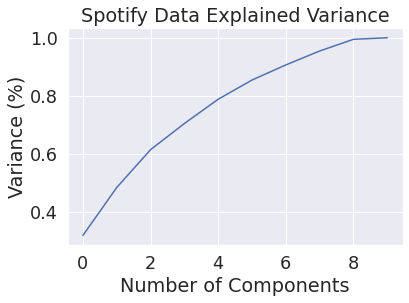

In [77]:
pca = PCA().fit(df_norm.iloc[:, 4:])
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Spotify Data Explained Variance')
plt.show()

We notice the explained variance for 2 components is too small, there is not enough of a linear relationship between features to use PCA, we then use k-PCA. 

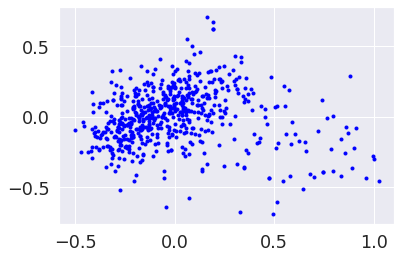

In [78]:
reduced_data = dtp.kpca_reduction( df_norm.iloc[:, 4:])
plt.figure()
plt.plot(reduced_data[:, [0]] , reduced_data[:, [1]], linestyle = 'none',
             marker = 'o', markersize = 3, color="blue" )
plt.show()


## Predictions and Models 

Trying to predict popularity


In [79]:
from sklearn.preprocessing import LabelEncoder

artist_le= LabelEncoder()
artist_labels = artist_le.fit_transform(df_norm['artist'])
df_norm['artist'] = artist_labels

top_genre = LabelEncoder()
label_genres = top_genre.fit_transform(df_norm['genre'])
df_norm['genre'] = label_genres

X = df.drop(['popularity', 'title', 'artist', 'year', 'genre'], axis = 1)
y = df['popularity']

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")


def cross_val_models(X, y):
    #model creation

    model_RF = RandomForestRegressor(n_estimators = 100,max_leaf_nodes = 2, random_state = 1)
    # model_XGB = XGBRegressor(n_estimators = 100, learning_rate = 0.5, n_jobs = 3, random_state = 42)
    lasso = Lasso(alpha =0.0005, random_state=1)
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    model_lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=300,
                              max_bin = 10, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 2, min_sum_hessian_in_leaf = 4)

    ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
    GBoost = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=4, 
                                   loss='huber', random_state =42)


    #averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

    
    kf = KFold(n_splits= 3, shuffle=True, random_state= 42)
    #Cross Validation
    scores1 = -1 * cross_val_score(model_RF, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error', )
    # scores3 = -1 * cross_val_score(model_XGB, X, y,
    #                               cv=kf,
    #                               scoring='neg_mean_absolute_error')
    scores4 = -1 * cross_val_score(lasso, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    scores5 = -1 * cross_val_score(model_lgb, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    scores6 = -1 * cross_val_score(ENet, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    scores7 = -1 * cross_val_score(KRR, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    # scores8 = -1 * cross_val_score(averaged_models, X, y,
    #                               cv=kf,
    #                               scoring='neg_mean_absolute_error')

    

    print('model_RF',scores1.mean(), scores1.std())
    # print('model_XGB', scores3.mean(), scores3.std())
    print('lasso', scores4.mean(), scores4.std())
    print('model_lgb', scores5.mean(), scores5.std())
    print('ENet', scores6.mean(), scores6.std())
    print('KRR', scores7.mean(), scores7.std())
    #print(" Averaged base models score: {:.4f} ({:.4f})\n".format(scores8.mean(), scores8.std()))
    

In [81]:
X_std = RobustScaler().fit_transform(X)
cross_val_models(X,y)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [War

Extra data is concatenated


In [82]:
df1= pd.read_csv('Spotify-2000.csv', encoding='ISO-8859-1')
df1 = df1.drop(['ï»¿Index', 'Title', 'Artist'], axis = 1)
df2 = df.drop(['title', 'artist'], axis = 1)
df1.columns = df2.columns 
df_conc = pd.concat([df2, df1], ignore_index=True)
df_conc['duration'] = pd.to_numeric(df_conc['duration'], errors = 'coerce')

genres = df['genre'].value_counts().index
df_conc = df_conc[df_conc['genre'].isin(genres)]

df_conc = df_conc.dropna()
df_conc = df_conc.drop_duplicates()


top_genre = LabelEncoder()
label_genres = top_genre.fit_transform(df_conc['genre'])
df_conc['genre'] = label_genres

X = df_conc.drop(['popularity', 'genre', 'year'], axis = 1)
y = df_conc['popularity']
X_rob = X.copy()
X_rob.loc[:, :] = RobustScaler().fit_transform(X)

cross_val_models(X, y)



[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [War

In [86]:
from sklearn.model_selection import GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid ):
    kf = KFold(n_splits= 3, shuffle=True, random_state= 42)
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=kf, 
        n_jobs= -1, 
        scoring= 'neg_mean_absolute_error',
    )
 
    fitted_model = gs.fit(X_train_data, y_train_data)
    best_model = fitted_model.best_estimator_
    pred = fitted_model.predict(X_test_data)

    score = mean_absolute_error(y_test_data, pred)

    return [best_model, score]



In [88]:
# Defining the hyperparameters to optimize
grid_parameters = [
    { # LightGBM
        'n_estimators': [500, 600],
        'learning_rate': [0.005, 0.0005],
        'colsample_bytree': [0.5, 0.7],
        'max_depth': [8, 9],
        'num_leaves': [18, 20, 22],
        'reg_alpha': [0.4, 0.3, 0.2],
        'reg_lambda': [1.1, 1.3],
        'min_split_gain': [0.3, 0.4],
        'subsample': [0.6, 0.8],
        'subsample_freq': [10, 9]
    }, 
    { # Random Forest
        'max_depth':[15, 20], 
        'n_estimators':[250, 300],
        'max_features':[2, 3],
        'min_samples_split' : [2, 5],
        'min_samples_leaf' : [1, 2, 3]
        
    },
    {
        #Lasso####
        'alpha': [0.005, 0.05] 
    },

    {
        #KernelRidge
        'alpha': [30, 50],
        'kernel' : ['polynomial'], 
        'degree' : [2, 3],
        'coef0' : [11, 9] 
    },
        #ElasticNet########
    {
        'alpha': [0.0005, 0.005],
        'l1_ratio' : [0.7, 0.5, 0.3] 
        
    },
    # GradientBoostingRegressor
    {
        'n_estimators' : [350, 370], 
        'learning_rate' : [0.005],
        'max_depth' : [5, 4, 3],
        'min_samples_leaf' : [2, 3],
        'min_samples_split' :[11, 12],
        'loss' : ['huber']
    }
]
def search_parameters(X, y, grid_parameters):        

    X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, 
                                    test_size=0.2, 
                                    random_state=42, shuffle = True)

    model_RF = RandomForestRegressor(random_state = 42)
    model_lasso = Lasso(random_state = 42)
    model_KRR = KernelRidge()
    model_lgb = LGBMRegressor(random_state = 42)
    model_ENet = ElasticNet(random_state = 42)
    model_GBoost = GradientBoostingRegressor(random_state = 42)

    models_to_train = [model_lgb, model_RF, model_lasso, model_KRR, model_ENet, model_GBoost]

    models_preds_scores = []

    for i, model in enumerate(models_to_train):
        print(i)
        params = grid_parameters[i]
        result = algorithm_pipeline(X_train, X_test, y_train, y_test, model, params)
        models_preds_scores.append(result)
        
    return models_preds_scores
        

In [89]:
scores = search_parameters(X_rob, y, grid_parameters) # takes some time
scores

0
1
2
3
4
5


[[LGBMRegressor(colsample_bytree=0.5, learning_rate=0.005, max_depth=9,
                min_split_gain=0.3, n_estimators=500, num_leaves=20,
                random_state=42, reg_alpha=0.3, reg_lambda=1.1, subsample=0.6,
                subsample_freq=9),
  10.201407411530589],
 [RandomForestRegressor(max_depth=15, max_features=2, n_estimators=300,
                        random_state=42),
  10.298718321666897],
 [Lasso(alpha=0.05, random_state=42), 10.333351517164743],
 [KernelRidge(alpha=30, coef0=11, degree=2, kernel='polynomial'),
  10.097304414836893],
 [ElasticNet(alpha=0.0005, random_state=42), 10.291735076896156],
 [GradientBoostingRegressor(learning_rate=0.005, loss='huber', min_samples_leaf=3,
                            min_samples_split=12, n_estimators=350,
                            random_state=42),
  10.522921087493746]]

Stacking models


In [90]:
best_parameters = []
for i in range(len(scores)):
    best_parameters.append(scores[i][0])

best_parameters

[LGBMRegressor(colsample_bytree=0.5, learning_rate=0.005, max_depth=9,
               min_split_gain=0.3, n_estimators=500, num_leaves=20,
               random_state=42, reg_alpha=0.3, reg_lambda=1.1, subsample=0.6,
               subsample_freq=9),
 RandomForestRegressor(max_depth=15, max_features=2, n_estimators=300,
                       random_state=42),
 Lasso(alpha=0.05, random_state=42),
 KernelRidge(alpha=30, coef0=11, degree=2, kernel='polynomial'),
 ElasticNet(alpha=0.0005, random_state=42),
 GradientBoostingRegressor(learning_rate=0.005, loss='huber', min_samples_leaf=3,
                           min_samples_split=12, n_estimators=350,
                           random_state=42)]

In [97]:
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor(regressors=(best_parameters),
                            meta_regressor=XGBRegressor(), cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42, 
                            n_jobs = 6)

X_train, X_test, y_train, y_test = train_test_split(
                                    X_rob, y, 
                                    test_size=0.2, 
                                    random_state=42, shuffle = True)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
mean_absolute_error(y_pred, y_test)
                                

12.011728525161743

In [95]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
       
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

averaged_models = AveragingModels(models = (best_parameters))
averaged_models.fit(X_train, y_train)
y_pred = averaged_models.predict(X_test)

mean_absolute_error(y_pred, y_test)

10.180666015852212

## Spotify API

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import requests
import json

CLIENT_ID = "8e0273854b3b41d5b0e5d57709dacee8"
CLIENT_SECRET = "a222499edd0b4a9d97d65c6a0698b244"

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '8e0273854b3b41d5b0e5d57709dacee8'
secret = 'a222499edd0b4a9d97d65c6a0698b244'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []
for i in range(0,10,50):
    track_results = sp.search(q='year:2017', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

        artist_uri = t['album']['artists'][0]['uri']
        artist_info = sp.artist(artist_uri)
        artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])

        try:
            genres.append(artist["genres"][0])
        except:
            genres.append(np.NaN)
        

        
        

In [ ]:
artist_uri = t['album']['artists'][0]['uri']
artist_info = sp.artist(artist_uri)
artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
artist["genres"][0]

In [ ]:
dict = {'title': track_name, 'artist': artist_name, 'top.genre': genres, 'year':2018}
pd.DataFrame(dict)